In [2]:
import numpy as np
import pandas as pd

import os
import random

import warnings

warnings.filterwarnings(action='ignore')

path = '/opt/ml/input/data/'
dat = pd.read_csv(path + 'FE_total2.csv')


In [3]:
dat.drop(['day','year','KnowledgeTag', 'last_answerCode7','last_answerCode8','last_answerCode9','last_answerCode10'], axis = 1, inplace = True)

In [4]:
_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] < 0]

In [5]:
# valid 제작하는 함수 새로 개편.
# 예전 valid 제작 함수는 1분 걸렸는데 0.6초만에 끗~
_train['train_valid'] = 0
_train.loc[_train.drop_duplicates(subset='userID', keep = 'last').index, 'train_valid'] = -1
_valid = _train[_train['train_valid'] == -1]
_train = _train[_train['train_valid'] == 0]

In [6]:
# 모델에 적용하기 전 기본적인 데이터 전처리 부분
## 라벨링, 필요없는 칼럼 제거
_train_value = _train['answerCode']
_train.drop(['Timestamp', 'testId', 'train_valid', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

_valid_value = _valid['answerCode']
_valid.drop(['Timestamp', 'testId', 'train_valid', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

_test.drop(['Timestamp', 'testId', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

In [7]:
# CatBoost에 적용하기 위해선 문자열 데이터로 변환 필요.
# 만약 범주형이 아니고 연속형(정수, 소수) 성질을 살리고 싶은 변수는 여기 drop에 적어두면 됨.(solve_time 같이.)
cat_columns = list(_train.drop(['solve_time','month'],axis=1).columns)

for col in cat_columns:
    _train[col] = _train[col].astype('str')
    _valid[col] = _valid[col].astype('str')
    _test[col] = _test[col].astype('str')

In [33]:

#!pip install catboost
# 가상환경에 패키지 설치 필요할듯
from catboost import CatBoostClassifier


# 하이퍼파라미터 수정할 여지가 많으니 추가나 수정하고 싶은 사람 수정해도 괜찮을듯.
# 일단 지난번에 사용했던 파라미터들 주석으로 들고 옴. 참고하면서 공부하면 좋을듯.

param = {
    "task_type" : "GPU",
    "eval_metric" : 'AUC',
    "devices" : '0',
    "random_state": 1998,
    'learning_rate': 0.01,
    'bagging_temperature': 0.05,
    'iterations': 4000,
    'max_depth': 8,
    'random_strength': 0,
    'l2_leaf_reg': 2e-7,
    'min_child_samples': 5, 
    'max_bin': 100, 
    'od_type': 'Iter',
    "cat_features" : list(_train),
    }

# model = CatBoostRegressor(**params_cat) 8436

# 실제 적용한 모델은 learning_rate, iterations(=n_estimators, 아마도?)만 사용함.
cat_model = CatBoostClassifier(**param)
cat_model.fit(_train, _train_value, early_stopping_rounds=100, verbose=200, eval_set=(_valid, _valid_value))


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8059343	best: 0.8059343 (0)	total: 361ms	remaining: 24m 4s
200:	test: 0.8396127	best: 0.8396127 (200)	total: 1m 5s	remaining: 20m 42s
400:	test: 0.8432704	best: 0.8433009 (397)	total: 2m 11s	remaining: 19m 36s
600:	test: 0.8435180	best: 0.8438681 (511)	total: 3m 15s	remaining: 18m 27s
bestTest = 0.8438681364
bestIteration = 511
Shrink model to first 512 iterations.


In [28]:
# valid score를 확인해봄.
# train 대비 valid score가 떨어짐. 과적합이 일어남. 마찬가지로 규제하는 하이퍼파라미터 필요.
from sklearn.metrics import accuracy_score, roc_auc_score

print('train score')
_train_pred = cat_model.predict_proba(_train)[:,1]
print(roc_auc_score(_train_value, _train_pred)) # auc
print(accuracy_score(_train_value, np.where(_train_pred >= 0.5, 1, 0))) # acc, 정확도

print('valid score')
_valid_pred = cat_model.predict_proba(_valid)[:,1]
print(roc_auc_score(_valid_value, _valid_pred)) # auc
print(accuracy_score(_valid_value, np.where(_valid_pred >= 0.5, 1, 0))) # acc, 정확도

train score
0.8973078375308887
0.8317869187941779
valid score
0.842285481598119
0.7632356893308251


Text(0.5, 1.0, 'Feature Importance')

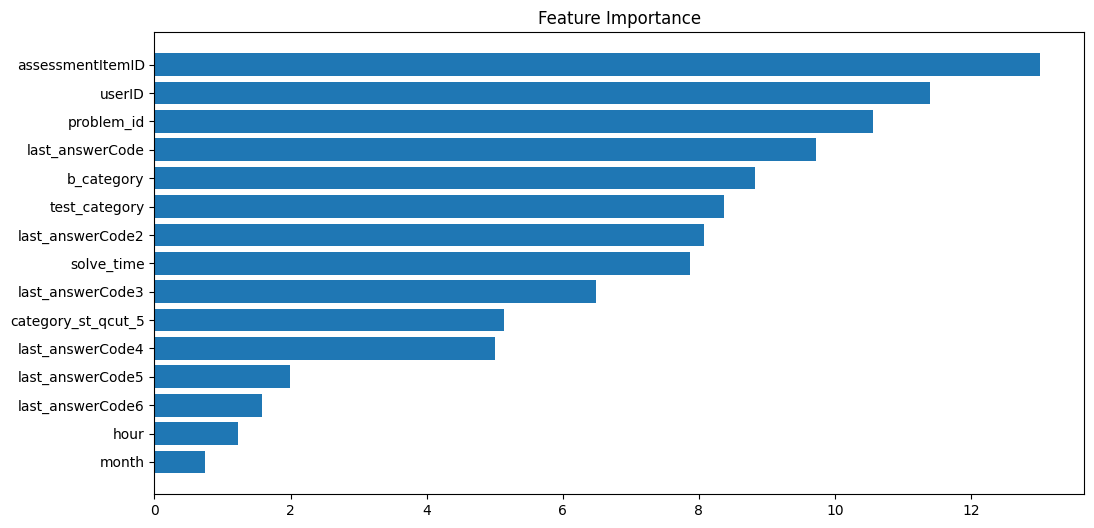

In [ ]:
import matplotlib.pyplot as plt

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(_valid.columns)[sorted_idx])
plt.title("Feature Importance")

In [34]:
# submission 제출하기 위한 코드

_test_pred = cat_model.predict_proba(_test)[:,1]
_test['prediction'] = _test_pred
submission = _test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('../output/cat12.csv', index = False)